#### loss function, optimizer
loss function : 손실 계산<br>
optimizer : 계산하는 방식<br>

* ALS 구현 예제 : https://yeomko.tistory.com/8

# ALS(교대 최소 제곱법)
  : 목적함수를 최적화하는 기법<br>
- 추천 알고리즘의 computation 환경인 분산처리 플랫폼에서는 GD(gradient descent)보다 ALS가 더욱 효과적이라고 알려져 있다. 이는 ALS의 계산 방법 때문인데, GD에서처럼 Loss에 대한 편미분값을 update gradient로 활용하는 것이 아닌, P와 Q 벡터 중 하나를 고정해놓고 교대로 계산하기 때문이다. 이러한 방법은 분산처리 환경에서 더욱 빠른 연산이 가능해진다. <br>
- 또한 ALS는 GD와 비교해볼때 sparse한 데이터에 robust한 모습을 보인다고 알려져 있다. <br>
- Spark에서는 MF의 기본 학습법을 ALS에 기반하여 ML library로 제공하는데, Implicit feedback에 최적화된 학습까지 제공한다.

## 식 정리

### 1. 개념

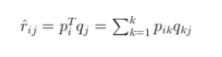

In [1]:
from PIL import Image
im1=Image.open('1.png')
im1

r : Input User-Item Rating Matrix<br>
r^ij : 추론된 값, predicted rating<br>
p : User Latent Vector<br>
q : Item Latent Vector<br>
* r > p,q(분해), 분해된 행렬을 곱하면 다시 원래의 r
* p,q의 요소들이 학습해야하는 변수 > r^ij를 얻기 위한 p_ik, q_kj를 구해야 함

### 2. cost 정의

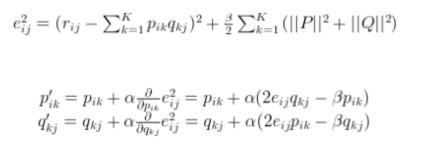

In [2]:
from PIL import Image
im2=Image.open('2.png')
im2

* 단순히 rating과 predicted rating간의 RMSE 이용<br>
  1) p_ik, q_jk들의 gradient를 구함<br>
  2) 정규화 파라미터를 일반적인 방법으로 cost에 추가<br>
  3) 순차적인 gradient descent 진행

### GD로 구현
batch를 조정하지 않은 gradient descent를 사용하였고, 변수들은 Numpy를 이용하여 보정하지 않은 완전한 랜덤 변수로 초기화하였다. <br>
정규화 파라미터는 위의 수식과 동일한 수식을 사용하였고 latent 보정을 위해 matrix global bias를 사용하였다.

In [ ]:
import numpy as np


class MatrixFactorization():
    def __init__(self, R, k, learning_rate, reg_param, epochs, verbose=False):
        """
        :param R: rating matrix
        :param k: latent parameter
        :param learning_rate: alpha on weight update
        :param reg_param: beta on weight update
        :param epochs: training epochs
        :param verbose: print status
        """

        self._R = R
        self._num_users, self._num_items = R.shape
        self._k = k
        self._learning_rate = learning_rate
        self._reg_param = reg_param
        self._epochs = epochs
        self._verbose = verbose


    def fit(self):
        """
        training Matrix Factorization : Update matrix latent weight and bias

        참고: self._b에 대한 설명
        - global bias: input R에서 평가가 매겨진 rating의 평균값을 global bias로 사용
        - 정규화 기능. 최종 rating에 음수가 들어가는 것 대신 latent feature에 음수가 포함되도록 해줌.

        :return: training_process
        """

        # init latent features
        self._P = np.random.normal(size=(self._num_users, self._k))
        self._Q = np.random.normal(size=(self._num_items, self._k))

        # init biases
        self._b_P = np.zeros(self._num_users)
        self._b_Q = np.zeros(self._num_items)
        self._b = np.mean(self._R[np.where(self._R != 0)])

        # train while epochs
        self._training_process = []
        for epoch in range(self._epochs):

            # rating이 존재하는 index를 기준으로 training
            for i in range(self._num_users):
                for j in range(self._num_items):
                    if self._R[i, j] > 0:
                        self.gradient_descent(i, j, self._R[i, j])
            cost = self.cost()
            self._training_process.append((epoch, cost))

            # print status
            if self._verbose == True and ((epoch + 1) % 10 == 0):
                print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))


    def cost(self):
        """
        compute root mean square error
        :return: rmse cost
        """

        # xi, yi: R[xi, yi]는 nonzero인 value를 의미한다.
        # 참고: http://codepractice.tistory.com/90
        xi, yi = self._R.nonzero()
        predicted = self.get_complete_matrix()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self._R[x, y] - predicted[x, y], 2)
        return np.sqrt(cost) / len(xi)


    def gradient(self, error, i, j):
        """
        gradient of latent feature for GD

        :param error: rating - prediction error
        :param i: user index
        :param j: item index
        :return: gradient of latent feature tuple
        """

        dp = (error * self._Q[j, :]) - (self._reg_param * self._P[i, :])
        dq = (error * self._P[i, :]) - (self._reg_param * self._Q[j, :])
        return dp, dq


    def gradient_descent(self, i, j, rating):
        """
        graident descent function

        :param i: user index of matrix
        :param j: item index of matrix
        :param rating: rating of (i,j)
        """

        # get error
        prediction = self.get_prediction(i, j)
        error = rating - prediction

        # update biases
        self._b_P[i] += self._learning_rate * (error - self._reg_param * self._b_P[i])
        self._b_Q[j] += self._learning_rate * (error - self._reg_param * self._b_Q[j])

        # update latent feature
        dp, dq = self.gradient(error, i, j)
        self._P[i, :] += self._learning_rate * dp
        self._Q[j, :] += self._learning_rate * dq


    def get_prediction(self, i, j):
        """
        get predicted rating: user_i, item_j
        :return: prediction of r_ij
        """
        return self._b + self._b_P[i] + self._b_Q[j] + self._P[i, :].dot(self._Q[j, :].T)


    def get_complete_matrix(self):
        """
        computer complete matrix PXQ + P.bias + Q.bias + global bias

        - PXQ 행렬에 b_P[:, np.newaxis]를 더하는 것은 각 열마다 bias를 더해주는 것
        - b_Q[np.newaxis:, ]를 더하는 것은 각 행마다 bias를 더해주는 것
        - b를 더하는 것은 각 element마다 bias를 더해주는 것

        - newaxis: 차원을 추가해줌. 1차원인 Latent들로 2차원의 R에 행/열 단위 연산을 해주기위해 차원을 추가하는 것.

        :return: complete matrix R^
        """
        return self._b + self._b_P[:, np.newaxis] + self._b_Q[np.newaxis:, ] + self._P.dot(self._Q.T)


    def print_results(self):
        """
        print fit results
        """

        print("User Latent P:")
        print(self._P)
        print("Item Latent Q:")
        print(self._Q.T)
        print("P x Q:")
        print(self._P.dot(self._Q.T))
        print("bias:")
        print(self._b)
        print("User Latent bias:")
        print(self._b_P)
        print("Item Latent bias:")
        print(self._b_Q)
        print("Final R matrix:")
        print(self.get_complete_matrix())
        print("Final RMSE:")
        print(self._training_process[self._epochs-1][1])


# run example
if __name__ == "__main__":
    # rating matrix - User X Item : (7 X 5)
    R = np.array([
        [1, 0, 0, 1, 3],
        [2, 0, 3, 1, 1],
        [1, 2, 0, 5, 0],
        [1, 0, 0, 4, 4],
        [2, 1, 5, 4, 0],
        [5, 1, 5, 4, 0],
        [0, 0, 0, 1, 0],
    ])

    # P, Q is (7 X k), (k X 5) matrix
    factorizer = MatrixFactorization(R, k=3, learning_rate=0.01, reg_param=0.01, epochs=300, verbose=True)
    factorizer.fit()
    factorizer.print_results()